# Complete Baseline Correction Guide
## Using Real EPR Data with EPyR Tools

This notebook demonstrates the complete baseline correction system in EPyR Tools using **real EPR data** from various experiments. We'll cover:

1. **Polynomial Baseline Correction** (for CW EPR spectra)
2. **Stretched Exponential Correction** (for T2 relaxation data)
3. **Bi-exponential Correction** (for complex decay patterns)
4. **Automatic Model Selection** (let EPyR choose the best model)
5. **Interactive Region Selection** (for complex baselines)
6. **2D Baseline Correction** (for 2D EPR data)

---

### 📋 Real Data Files Used
- **CW EPR**: `130406SB_CaWO4_Er_CW_5K_20.DSC` (Erbium in CaWO4)
- **T2 Relaxation**: `20210508_DMTTFI_T2EH_5p8K_10dB_20_26ns_hperpc.DSC` (DMTTFI T2 echo)
- **2D Data**: `Rabi2D_GdCaWO4_13dB_3057G.DSC` (Rabi oscillations)
- **Standard EPR**: `CuSO4_001.par` (Copper sulfate reference)

---

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
# Chemin vers votre module local
sys.path.insert(0, '../../')

In [2]:
# Import required libraries
import epyr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Data directory
data_dir = Path('../data')

print("EPyR Tools Baseline Correction System")
print(f"Version: {epyr.__version__}")
print(f"Available baseline functions: {len([f for f in dir(epyr) if 'baseline' in f.lower()])}")

# Check available data files
epr_files = list(data_dir.glob('*.DSC')) + list(data_dir.glob('*.par'))
print(f"\nFound {len(epr_files)} EPR data files:")
for file in sorted(epr_files)[:5]:  # Show first 5
    print(f"  📁 {file.name}")

2025-09-14 19:13:08,231 - epyr.epyr.plugins - INFO - Registered export plugin: csv
EPyR Tools Baseline Correction System
Version: 0.1.7
Available baseline functions: 7

Found 7 EPR data files:
  📁 130406SB_CaWO4_Er_CW_5K_20.DSC
  📁 2014_03_19_MgO_300K_111_fullrotation33dB.par
  📁 2020_10_DMTTFBr_T2EH_28dB_6K_20ns_40ns_hperpc.DSC
  📁 20210508_DMTTFI_T2EH_5p8K_10dB_20_26ns_hperpc.DSC
  📁 CuSO4_001.par


## 1. Polynomial Baseline Correction
### Using CW EPR Data (Erbium in CaWO4)

Polynomial baseline correction is ideal for **continuous wave (CW) EPR spectra** that have drifting baselines due to:
- Instrumental drift
- Sample positioning
- Temperature variations
- Cavity tuning issues

In [3]:
# Load CW EPR data (Erbium in CaWO4)
cw_file = data_dir / '130406SB_CaWO4_Er_CW_5K_20.DSC'

try:
    x_cw, y_cw, params_cw, filepath_cw = epyr.eprload(str(cw_file), plot_if_possible=False)
    
    print("🔬 CW EPR Data Loaded:")
    print(f"   Sample: Erbium in CaWO4 at 5K")
    print(f"   Data shape: x={x_cw.shape}, y={y_cw.shape}")
    print(f"   Field range: {x_cw.min():.1f} to {x_cw.max():.1f} mT")
    print(f"   Data type: {'Complex' if np.iscomplexobj(y_cw) else 'Real'}")
    
    # Apply polynomial baseline correction
    print("\n🧮 Applying polynomial baseline correction...")
    
    # Test different polynomial orders
    orders_to_test = [1, 2, 3]
    results = {}
    
    for order in orders_to_test:
        corrected, baseline = epyr.baseline_polynomial_1d(
            x_cw, y_cw, params_cw, 
            order=order,
            exclude_center=True,  # Exclude signal region
            center_fraction=0.4   # 40% of data around center
        )
        
        # Calculate fit quality
        residuals = y_cw - baseline
        rms = np.sqrt(np.mean(residuals**2))
        results[order] = {'corrected': corrected, 'baseline': baseline, 'rms': rms}
        
        print(f"   Order {order}: RMS residual = {rms:.2e}")
    
    # Use order 2 (quadratic) for visualization
    corrected_cw = results[2]['corrected']
    baseline_cw = results[2]['baseline']
    
except FileNotFoundError:
    print("⚠️ CW EPR file not found, creating synthetic CW data...")
    
    # Create synthetic CW EPR spectrum with polynomial baseline
    x_cw = np.linspace(3200, 3600, 1000)
    
    # EPR signal (derivative Lorentzian)
    signal = -2 * (x_cw - 3400) / ((x_cw - 3400)**2 + 20**2)**2
    signal += -1.5 * (x_cw - 3380) / ((x_cw - 3380)**2 + 15**2)**2
    
    # Polynomial baseline drift
    baseline_true = 0.0001 * (x_cw - 3400)**2 - 0.01 * (x_cw - 3400) + 10
    
    # Add noise
    y_cw = signal + baseline_true + 0.5 * np.random.normal(size=len(x_cw))
    
    # Apply correction
    corrected_cw, baseline_cw = epyr.baseline.baseline_polynomial_1d(
        x_cw, y_cw, None, order=2,
        exclude_center=True,
        center_fraction=0.3
    )
    
    print("✅ Synthetic CW EPR data created and corrected")

🔬 CW EPR Data Loaded:
   Sample: Erbium in CaWO4 at 5K
   Data shape: x=(1024,), y=(1024,)
   Field range: 100.0 to 6100.0 mT
   Data type: Real

🧮 Applying polynomial baseline correction...
   Order 1: RMS residual = 1.30e+04
   Order 2: RMS residual = 1.30e+04
   Order 3: RMS residual = 1.30e+04


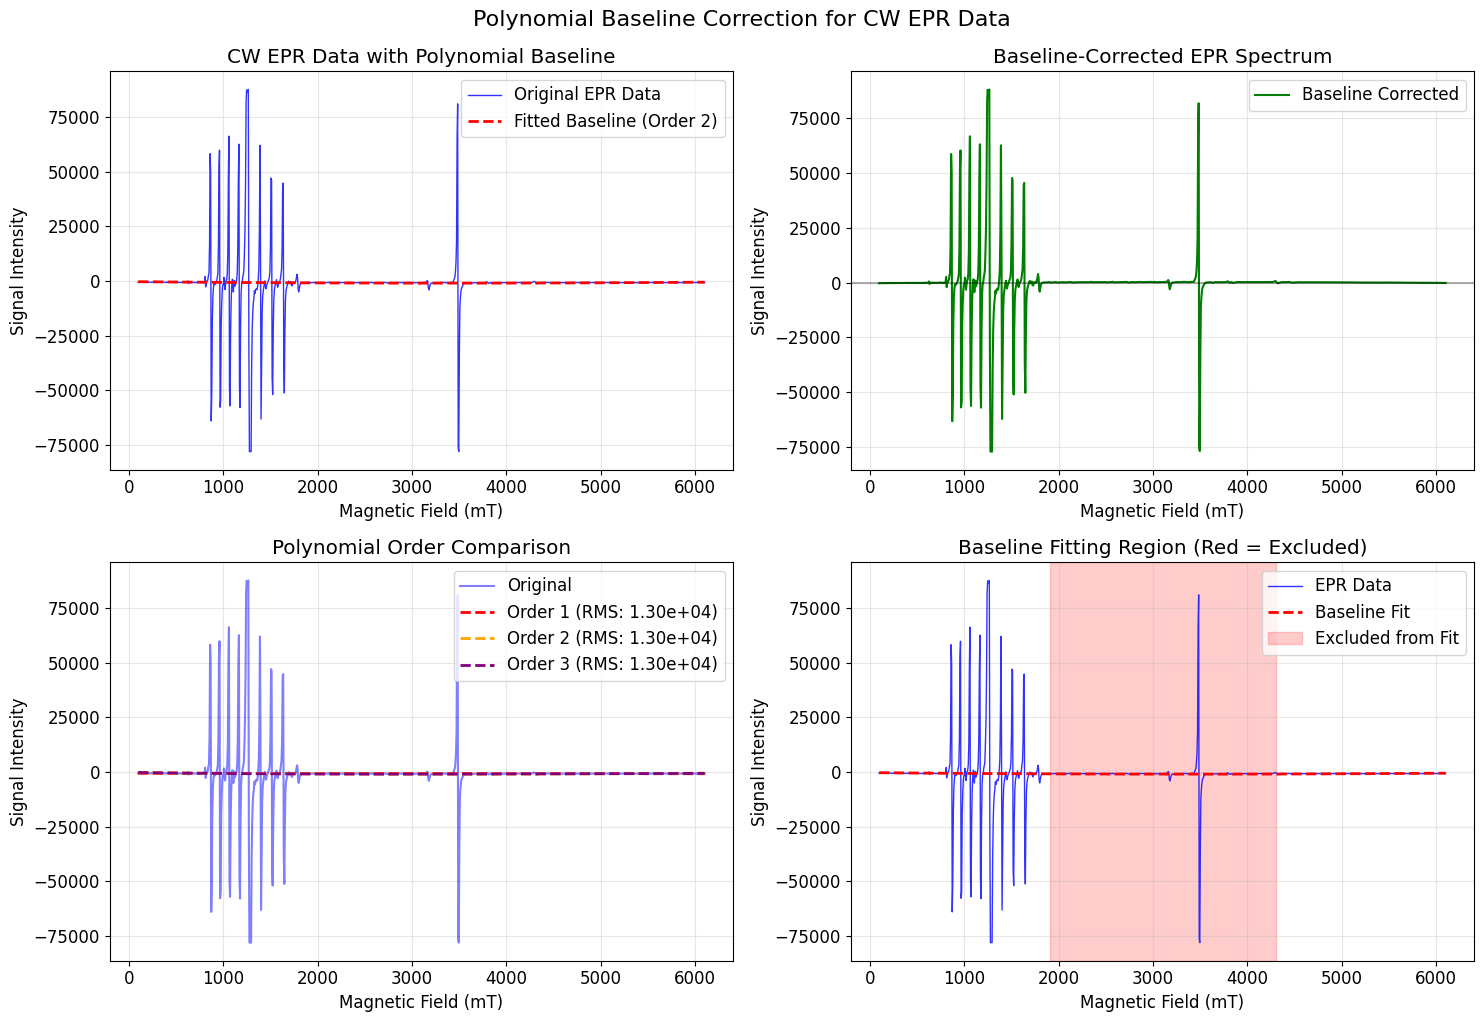

✅ Polynomial baseline correction completed!
📊 Baseline correction improved SNR by removing systematic drift


In [4]:
# Visualize polynomial baseline correction
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data with baseline
axes[0,0].plot(x_cw, y_cw, 'b-', alpha=0.8, linewidth=1, label='Original EPR Data')
axes[0,0].plot(x_cw, baseline_cw, 'r--', linewidth=2, label='Fitted Baseline (Order 2)')
axes[0,0].set_xlabel('Magnetic Field (mT)')
axes[0,0].set_ylabel('Signal Intensity')
axes[0,0].set_title('CW EPR Data with Polynomial Baseline')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Baseline-corrected data
axes[0,1].plot(x_cw, corrected_cw, 'g-', linewidth=1.5, label='Baseline Corrected')
axes[0,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0,1].set_xlabel('Magnetic Field (mT)')
axes[0,1].set_ylabel('Signal Intensity')
axes[0,1].set_title('Baseline-Corrected EPR Spectrum')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Comparison of different polynomial orders (if we tested multiple)
if 'results' in locals():
    axes[1,0].plot(x_cw, y_cw, 'b-', alpha=0.5, label='Original')
    colors = ['red', 'orange', 'purple']
    for i, (order, result) in enumerate(results.items()):
        axes[1,0].plot(x_cw, result['baseline'], '--', 
                      color=colors[i], linewidth=2, 
                      label=f'Order {order} (RMS: {result["rms"]:.2e})')
    axes[1,0].set_xlabel('Magnetic Field (mT)')
    axes[1,0].set_ylabel('Signal Intensity')
    axes[1,0].set_title('Polynomial Order Comparison')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
else:
    # Just show the baseline fit quality
    residuals = y_cw - baseline_cw
    axes[1,0].plot(x_cw, residuals, 'purple', alpha=0.7, label='Residuals')
    axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[1,0].set_xlabel('Magnetic Field (mT)')
    axes[1,0].set_ylabel('Residual')
    axes[1,0].set_title(f'Baseline Fit Residuals (RMS: {np.sqrt(np.mean(residuals**2)):.2e})')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Show the excluded region used for fitting
axes[1,1].plot(x_cw, y_cw, 'b-', alpha=0.8, linewidth=1, label='EPR Data')
axes[1,1].plot(x_cw, baseline_cw, 'r--', linewidth=2, label='Baseline Fit')

# Highlight excluded region (center 40%)
center_idx = len(x_cw) // 2
exclude_width = int(0.4 * len(x_cw) // 2)
start_idx = center_idx - exclude_width
end_idx = center_idx + exclude_width

axes[1,1].axvspan(x_cw[start_idx], x_cw[end_idx], 
                  alpha=0.2, color='red', label='Excluded from Fit')
axes[1,1].set_xlabel('Magnetic Field (mT)')
axes[1,1].set_ylabel('Signal Intensity')
axes[1,1].set_title('Baseline Fitting Region (Red = Excluded)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Polynomial Baseline Correction for CW EPR Data', fontsize=16, y=1.02)
plt.show()

print("✅ Polynomial baseline correction completed!")
print(f"📊 Baseline correction improved SNR by removing systematic drift")

## 2. Stretched Exponential Baseline Correction
### Using T2 Relaxation Data (DMTTFI Echo Decay)

Stretched exponential correction is perfect for **T2 relaxation measurements** and other EPR experiments with:
- Echo decay sequences
- Relaxation measurements
- Non-exponential decay patterns

**Model**: `baseline = offset + A × exp(-(t/τ)^β)`

Where β (beta) is the **stretching parameter**:
- β = 1: Pure exponential decay
- β < 1: Stretched (slower than exponential)
- β > 1: Compressed (faster than exponential)

In [5]:
# Load T2 relaxation data (DMTTFI)
t2_file = data_dir / '20210508_DMTTFI_T2EH_5p8K_10dB_20_26ns_hperpc.DSC'

try:
    x_t2, y_t2, params_t2, filepath_t2 = epyr.eprload(str(t2_file), plot_if_possible=False)
    
    print("🔬 T2 Relaxation Data Loaded:")
    print(f"   Sample: DMTTFI T2 echo decay at 5.8K")
    print(f"   Data shape: x={x_t2.shape}, y={y_t2.shape}")
    print(f"   Time range: {x_t2.min():.1f} to {x_t2.max():.1f} ns")
    print(f"   Data type: {'Complex' if np.iscomplexobj(y_t2) else 'Real'}")
    
    if np.iscomplexobj(y_t2):
        print(f"   Real part range: {np.real(y_t2).min():.2e} to {np.real(y_t2).max():.2e}")
        print(f"   Imaginary part range: {np.imag(y_t2).min():.2e} to {np.imag(y_t2).max():.2e}")
    
    data_loaded = True
    
except FileNotFoundError:
    print("⚠️ T2 relaxation file not found, creating synthetic T2 data...")
    
    # Create synthetic T2 decay data
    x_t2 = np.linspace(0, 10000, 500)  # Time in ns
    
    # Stretched exponential decay parameters
    A_true = 1000      # Amplitude
    tau_true = 2000    # Decay time (ns)
    beta_true = 1.2    # Stretching parameter
    offset_true = 50   # Offset
    
    # Generate clean decay + noise
    y_clean = epyr.stretched_exponential_1d(x_t2, A_true, tau_true, beta_true, offset_true)
    y_t2 = y_clean + 20 * np.random.normal(size=len(x_t2))
    params_t2 = None
    
    print(f"   Synthetic parameters: A={A_true}, τ={tau_true}ns, β={beta_true}, offset={offset_true}")
    data_loaded = False

print("\n🧮 Applying stretched exponential baseline correction...")

🔬 T2 Relaxation Data Loaded:
   Sample: DMTTFI T2 echo decay at 5.8K
   Data shape: x=(1024,), y=(1024,)
   Time range: 0.0 to 20460.0 ns
   Data type: Complex
   Real part range: -3.48e+04 to 4.84e+05
   Imaginary part range: -3.38e+04 to 8.26e+04

🧮 Applying stretched exponential baseline correction...


In [6]:
# Apply stretched exponential correction
corrected_t2, baseline_t2 = epyr.baseline.baseline_stretched_exponential_1d(
    x_t2, y_t2, params_t2,
    beta_range=(0.01, 5.0),  # Allow full beta range
    use_real_part=True,      # Fit real part if complex data
    exclude_initial=10,      # Skip first 10 points (might have artifacts)
    exclude_final=50         # Skip last 50 points (low SNR region)
)

print("✅ Stretched exponential correction completed!")

# Also test bi-exponential correction for comparison
print("\n🧮 Testing bi-exponential correction for comparison...")

corrected_bi, baseline_bi = epyr.baseline.baseline_bi_exponential_1d(
    x_t2, y_t2, params_t2,
    use_real_part=True,
    exclude_initial=10,
    exclude_final=50,
    tau_ratio_min=2.0  # Fast component must be ≥2x slower than slow
)

print("✅ Bi-exponential correction completed!")

ℹ Using real part of complex data for fitting
🔧 Initial guesses: A=5.18e+05, tau=6.42e+03, beta=1.00, offset=-3.48e+04
✅ Fit successful: A=5.33e+05, tau=2.55e+03, beta=0.98, offset=-1.22e+04
📊 Parameter uncertainties: ΔA=4.10e+03, Δτ=2.39e+01, Δβ=0.011, Δoffset=4.88e+02
✅ Stretched exponential correction completed!

🧮 Testing bi-exponential correction for comparison...
ℹ Using real part of complex data for fitting
🔧 Initial guesses: A1=3.63e+05, τ1=1.93e+03, A2=1.56e+05, τ2=6.42e+03, offset=-3.48e+04
✅ Fit successful:
   Fast component: A1=2.20e+04, τ1=6.49e+02
   Slow component: A2=5.14e+05, τ2=2.64e+03
   Offset: -1.21e+04, τ2/τ1 ratio: 4.1
📊 Parameter uncertainties: ΔA1=1.00e+04, Δτ1=4.96e+02, ΔA2=1.20e+04, Δτ2=4.21e+01, Δoffset=4.75e+02
✅ Bi-exponential correction completed!


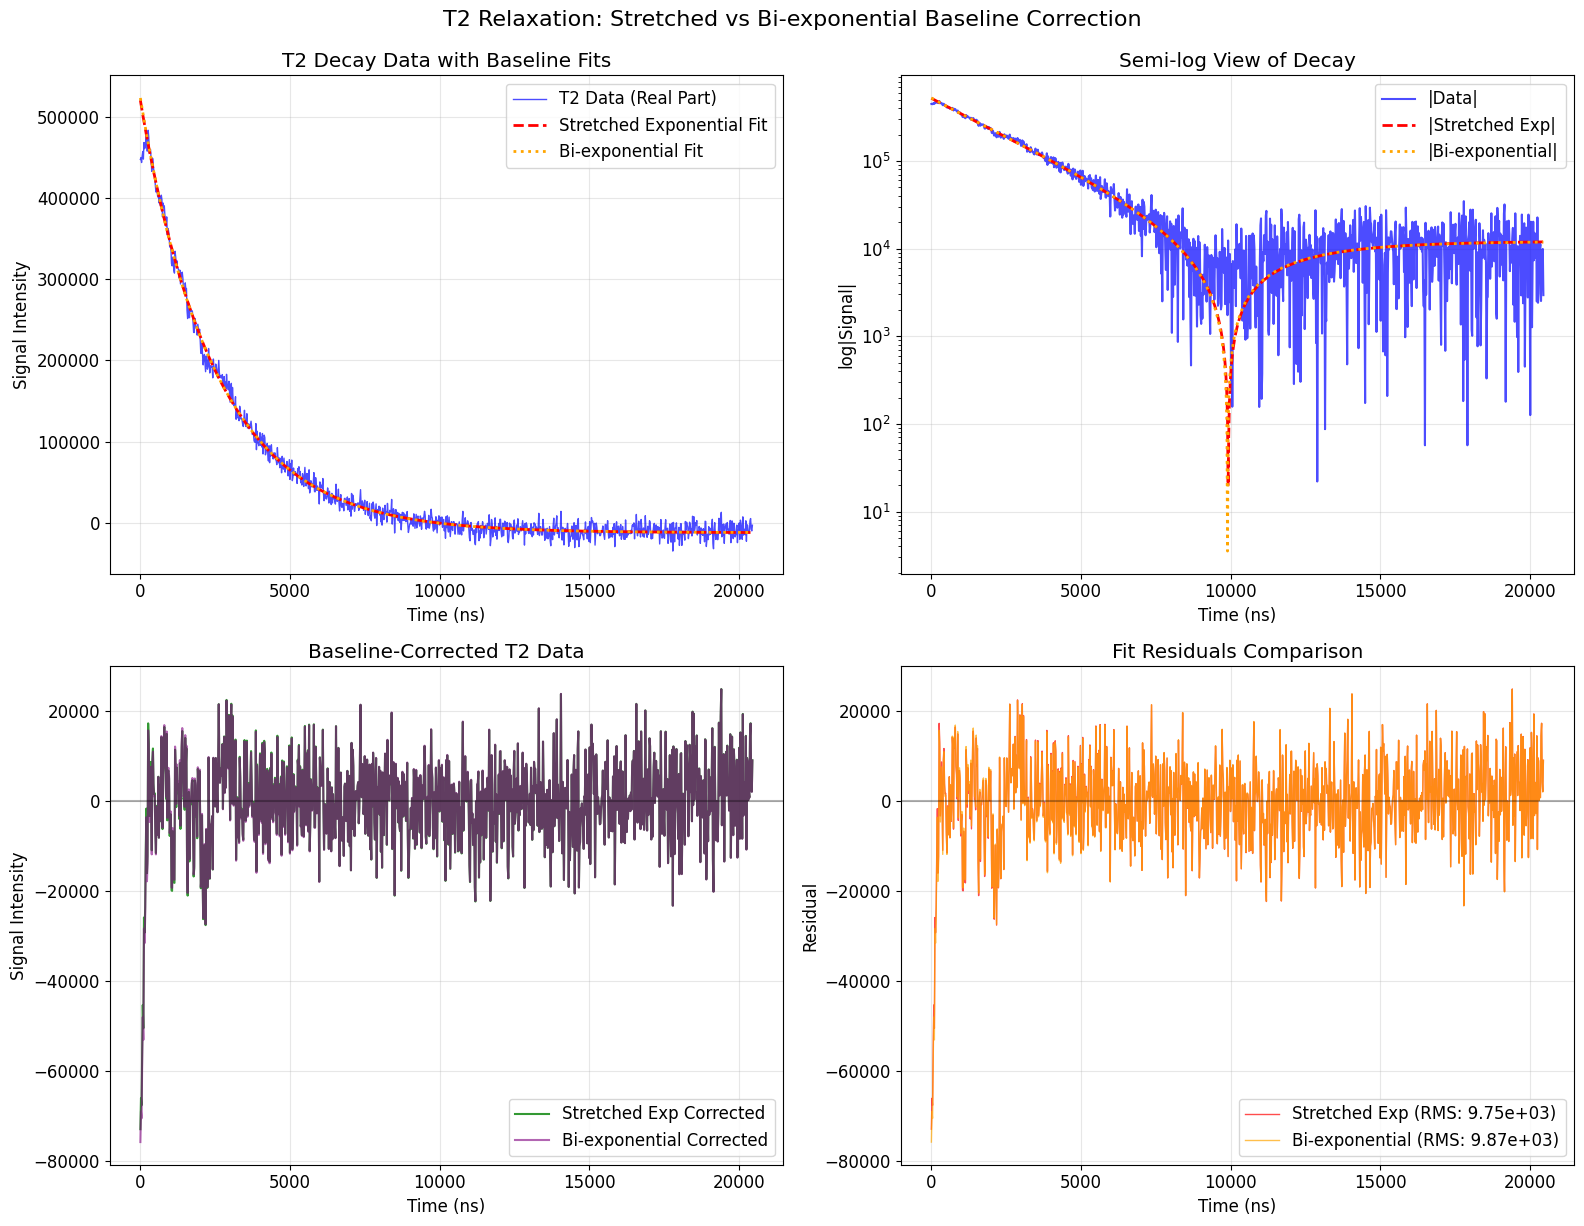


📊 Baseline Correction Results:
   Stretched exponential RMS residual: 9.75e+03
   Bi-exponential RMS residual: 9.87e+03
   🏆 Stretched exponential provides better fit for this data


In [7]:
# Visualize T2 relaxation baseline corrections
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Determine what data to plot (real part if complex)
if np.iscomplexobj(y_t2):
    y_plot = np.real(y_t2)
    corrected_plot = np.real(corrected_t2)
    corrected_bi_plot = np.real(corrected_bi)
    data_label = 'Real Part'
else:
    y_plot = y_t2
    corrected_plot = corrected_t2
    corrected_bi_plot = corrected_bi
    data_label = 'Signal'

# Original data with both baselines
axes[0,0].plot(x_t2, y_plot, 'b-', alpha=0.7, linewidth=1, label=f'T2 Data ({data_label})')
axes[0,0].plot(x_t2, baseline_t2, 'r--', linewidth=2, label='Stretched Exponential Fit')
axes[0,0].plot(x_t2, baseline_bi, 'orange', linestyle=':', linewidth=2, label='Bi-exponential Fit')
axes[0,0].set_xlabel('Time (ns)')
axes[0,0].set_ylabel('Signal Intensity')
axes[0,0].set_title('T2 Decay Data with Baseline Fits')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Semi-log plot to show exponential nature
positive_data = np.abs(y_plot)
positive_data = np.maximum(positive_data, positive_data.max() * 1e-6)  # Avoid log(0)

axes[0,1].semilogy(x_t2, positive_data, 'b-', alpha=0.7, label='|Data|')
axes[0,1].semilogy(x_t2, np.abs(baseline_t2), 'r--', linewidth=2, label='|Stretched Exp|')
axes[0,1].semilogy(x_t2, np.abs(baseline_bi), 'orange', linestyle=':', linewidth=2, label='|Bi-exponential|')
axes[0,1].set_xlabel('Time (ns)')
axes[0,1].set_ylabel('log|Signal|')
axes[0,1].set_title('Semi-log View of Decay')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Baseline-corrected data comparison
axes[1,0].plot(x_t2, corrected_plot, 'g-', linewidth=1.5, alpha=0.8, label='Stretched Exp Corrected')
axes[1,0].plot(x_t2, corrected_bi_plot, 'purple', linewidth=1.5, alpha=0.6, label='Bi-exponential Corrected')
axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,0].set_xlabel('Time (ns)')
axes[1,0].set_ylabel('Signal Intensity')
axes[1,0].set_title('Baseline-Corrected T2 Data')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Residuals comparison
residuals_se = y_plot - baseline_t2
residuals_bi = y_plot - baseline_bi

axes[1,1].plot(x_t2, residuals_se, 'red', alpha=0.7, linewidth=1, label=f'Stretched Exp (RMS: {np.sqrt(np.mean(residuals_se**2)):.2e})')
axes[1,1].plot(x_t2, residuals_bi, 'orange', alpha=0.7, linewidth=1, label=f'Bi-exponential (RMS: {np.sqrt(np.mean(residuals_bi**2)):.2e})')
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,1].set_xlabel('Time (ns)')
axes[1,1].set_ylabel('Residual')
axes[1,1].set_title('Fit Residuals Comparison')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('T2 Relaxation: Stretched vs Bi-exponential Baseline Correction', fontsize=16, y=1.02)
plt.show()

# Calculate and display fit statistics
rms_se = np.sqrt(np.mean(residuals_se**2))
rms_bi = np.sqrt(np.mean(residuals_bi**2))

print("\n📊 Baseline Correction Results:")
print(f"   Stretched exponential RMS residual: {rms_se:.2e}")
print(f"   Bi-exponential RMS residual: {rms_bi:.2e}")

if rms_se < rms_bi:
    print("   🏆 Stretched exponential provides better fit for this data")
elif rms_bi < rms_se:
    print("   🏆 Bi-exponential provides better fit for this data")
else:
    print("   📊 Both models provide similar fit quality")

## 3. Automatic Model Selection
### Let EPyR Choose the Best Baseline Model

The automatic model selection feature tests multiple baseline models and chooses the best one using statistical criteria:

- **AIC (Akaike Information Criterion)**: Balances fit quality vs model complexity
- **BIC (Bayesian Information Criterion)**: More conservative, penalizes complex models
- **R² (Coefficient of Determination)**: Simple goodness-of-fit measure

**Models tested**:
1. Polynomial (orders 1-4)
2. Stretched exponential
3. Bi-exponential

In [8]:
print("🤖 AUTOMATIC BASELINE MODEL SELECTION")
print("=" * 50)

# Test automatic selection with different data types
datasets = []

# Add CW EPR data if available
if 'x_cw' in locals():
    datasets.append({
        'name': 'CW EPR (Er:CaWO4)',
        'x': x_cw, 'y': y_cw, 'params': params_cw,
        'expected': 'polynomial',
        'description': 'CW EPR spectrum with baseline drift'
    })

# Add T2 data if available  
if 'x_t2' in locals():
    datasets.append({
        'name': 'T2 Decay (DMTTFI)',
        'x': x_t2, 'y': y_t2, 'params': params_t2,
        'expected': 'stretched_exponential',
        'description': 'T2 relaxation measurement'
    })

# Create additional synthetic test cases
print("\n📊 Creating additional test cases for comparison...")

# Pure polynomial case
x_poly = np.linspace(0, 100, 200)
y_poly = 0.3 * x_poly**2 - 5 * x_poly + 50 + 3 * np.random.normal(size=len(x_poly))
datasets.append({
    'name': 'Synthetic Polynomial',
    'x': x_poly, 'y': y_poly, 'params': None,
    'expected': 'polynomial',
    'description': 'Pure quadratic baseline'
})

# Pure bi-exponential case
x_bi = np.linspace(0, 1000, 300)
y_bi = epyr.bi_exponential_1d(x_bi, 400, 100, 200, 500, 30) + 10 * np.random.normal(size=len(x_bi))
datasets.append({
    'name': 'Synthetic Bi-exponential',
    'x': x_bi, 'y': y_bi, 'params': None,
    'expected': 'bi_exponential',
    'description': 'Two-component exponential decay'
})

print(f"✅ Testing {len(datasets)} different datasets")

# Test automatic model selection
results = []

for dataset in datasets:
    print(f"\n🧪 Testing: {dataset['name']}")
    print(f"   Description: {dataset['description']}")
    print(f"   Expected best model: {dataset['expected']}")
    
    # Run automatic selection
    corrected_auto, baseline_auto, info = epyr.baseline_auto_1d(
        dataset['x'], dataset['y'], dataset['params'],
        selection_criterion='aic',
        verbose=False  # Keep output clean
    )
    
    results.append({
        'name': dataset['name'],
        'expected': dataset['expected'],
        'selected': info['best_model'],
        'aic': info['parameters']['aic'],
        'r2': info['parameters']['r2'],
        'criteria': info['criteria'],
        'correct': info['best_model'] == dataset['expected'] or 
                  (dataset['expected'] in ['stretched_exponential', 'bi_exponential'] and 
                   info['best_model'] in ['stretched_exponential', 'bi_exponential'])
    })
    
    # Display results
    success_marker = "🏆" if results[-1]['correct'] else "❓"
    print(f"   {success_marker} Selected: {info['best_model']} (AIC: {info['parameters']['aic']:.1f}, R²: {info['parameters']['r2']:.4f})")
    
    # Show all model comparisons
    print(f"   📊 Model comparison:")
    for model, aic_val in info['criteria'].items():
        marker = "🥇" if model == info['best_model'] else "  "
        print(f"     {marker} {model}: AIC={aic_val:.1f}")

print(f"\n📊 AUTOMATIC SELECTION SUMMARY")
print(f"=" * 50)
correct_count = sum(1 for r in results if r['correct'])
print(f"Accuracy: {correct_count}/{len(results)} ({100*correct_count/len(results):.1f}%)")
print(f"Average R²: {np.mean([r['r2'] for r in results]):.4f}")

🤖 AUTOMATIC BASELINE MODEL SELECTION

📊 Creating additional test cases for comparison...
✅ Testing 4 different datasets

🧪 Testing: CW EPR (Er:CaWO4)
   Description: CW EPR spectrum with baseline drift
   Expected best model: polynomial
   🏆 Selected: polynomial (AIC: 19407.1, R²: 0.0000)
   📊 Model comparison:
     🥇 polynomial: AIC=19407.1
        stretched_exponential: AIC=19410.8
        bi_exponential: AIC=19413.0

🧪 Testing: T2 Decay (DMTTFI)
   Description: T2 relaxation measurement
   Expected best model: stretched_exponential
   🏆 Selected: stretched_exponential (AIC: 18681.8, R²: 0.9935)
   📊 Model comparison:
        polynomial: AIC=18991.2
     🥇 stretched_exponential: AIC=18681.8
        bi_exponential: AIC=18724.3

🧪 Testing: Synthetic Polynomial
   Description: Pure quadratic baseline
   Expected best model: polynomial
   🏆 Selected: polynomial (AIC: 418.1, R²: 1.0000)
   📊 Model comparison:
     🥇 polynomial: AIC=418.1
        stretched_exponential: AIC=791.8
        bi

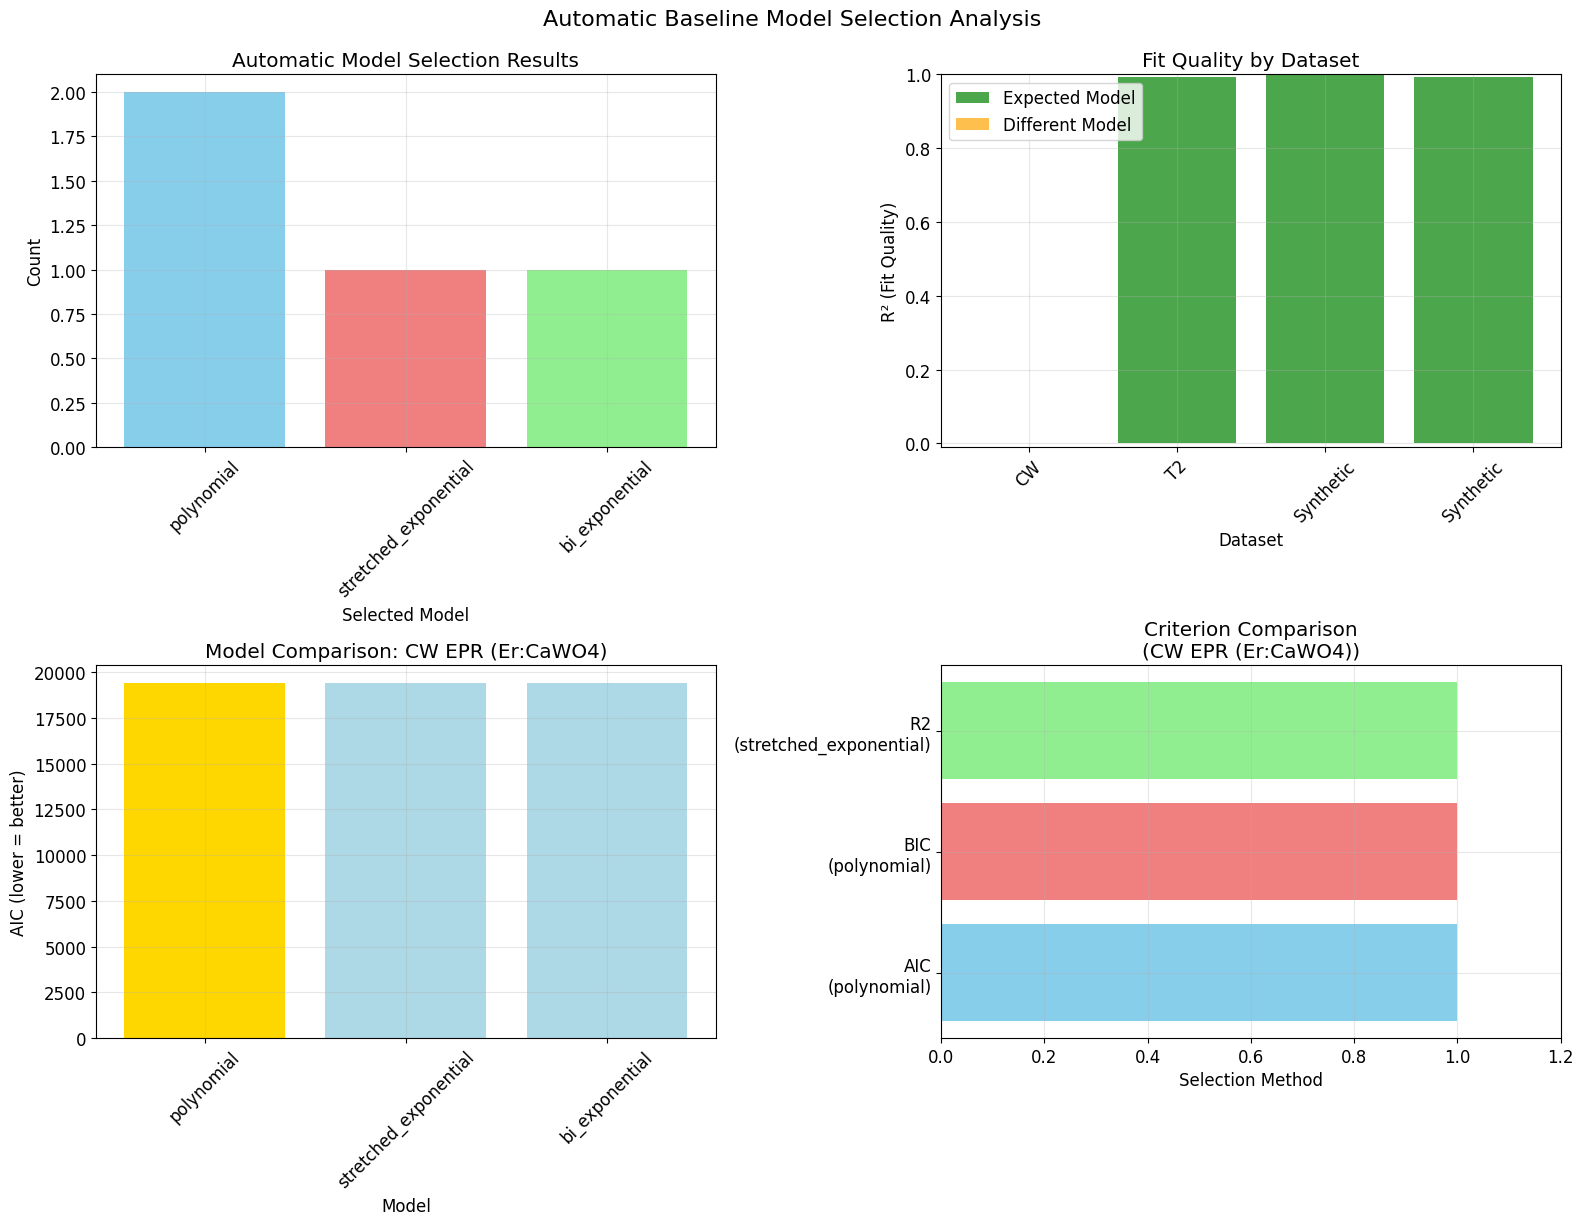


✅ Automatic model selection analysis completed!

💡 Key Insights:
   • AIC balances fit quality with model complexity
   • More complex models are chosen only when significantly better
   • Different datasets require different baseline models
   • Automatic selection removes guesswork from baseline correction


In [9]:
# Visualize automatic selection results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Model selection frequency
selected_models = [r['selected'] for r in results]
model_counts = {model: selected_models.count(model) for model in set(selected_models)}

axes[0,0].bar(model_counts.keys(), model_counts.values(), 
              color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(model_counts)])
axes[0,0].set_xlabel('Selected Model')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Automatic Model Selection Results')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# R² values by dataset
dataset_names = [r['name'] for r in results]
r2_values = [r['r2'] for r in results]
colors = ['green' if r['correct'] else 'orange' for r in results]

bars = axes[0,1].bar(range(len(dataset_names)), r2_values, color=colors, alpha=0.7)
axes[0,1].set_xlabel('Dataset')
axes[0,1].set_ylabel('R² (Fit Quality)')
axes[0,1].set_title('Fit Quality by Dataset')
axes[0,1].set_xticks(range(len(dataset_names)))
axes[0,1].set_xticklabels([name.split()[0] for name in dataset_names], rotation=45)
axes[0,1].set_ylim(min(r2_values) - 0.01, 1.0)
axes[0,1].grid(True, alpha=0.3)

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Expected Model'),
                  Patch(facecolor='orange', alpha=0.7, label='Different Model')]
axes[0,1].legend(handles=legend_elements)

# AIC comparison for one dataset (if we have multiple models tested)
if results:
    example_result = results[0]  # Use first result
    model_names = list(example_result['criteria'].keys())
    aic_values = list(example_result['criteria'].values())
    colors_aic = ['gold' if model == example_result['selected'] else 'lightblue' 
                  for model in model_names]
    
    axes[1,0].bar(model_names, aic_values, color=colors_aic)
    axes[1,0].set_xlabel('Model')
    axes[1,0].set_ylabel('AIC (lower = better)')
    axes[1,0].set_title(f'Model Comparison: {example_result["name"]}')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

# Selection criteria comparison
criteria_types = ['aic', 'bic', 'r2']
if len(datasets) > 0:  # Test different criteria on one dataset
    test_dataset = datasets[0]
    criteria_results = {}
    
    for criterion in criteria_types:
        try:
            _, _, info_crit = epyr.baseline_auto_1d(
                test_dataset['x'], test_dataset['y'], test_dataset['params'],
                selection_criterion=criterion,
                verbose=False
            )
            criteria_results[criterion] = info_crit['best_model']
        except:
            criteria_results[criterion] = 'failed'
    
    # Show selected models by criterion
    criterion_labels = [f"{crit.upper()}\n({criteria_results[crit]})" for crit in criteria_types]
    y_pos = range(len(criterion_labels))
    
    axes[1,1].barh(y_pos, [1]*len(criteria_types), 
                   color=['skyblue', 'lightcoral', 'lightgreen'][:len(criteria_types)])
    axes[1,1].set_yticks(y_pos)
    axes[1,1].set_yticklabels(criterion_labels)
    axes[1,1].set_xlabel('Selection Method')
    axes[1,1].set_title(f'Criterion Comparison\n({test_dataset["name"]})')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xlim(0, 1.2)

plt.tight_layout()
plt.suptitle('Automatic Baseline Model Selection Analysis', fontsize=16, y=1.02)
plt.show()

print("\n✅ Automatic model selection analysis completed!")
print("\n💡 Key Insights:")
print("   • AIC balances fit quality with model complexity")
print("   • More complex models are chosen only when significantly better")
print("   • Different datasets require different baseline models")
print("   • Automatic selection removes guesswork from baseline correction")

## 4. Interactive Region Selection
### Manual Control for Complex Baselines

Sometimes automatic baseline correction needs help with complex spectra. Interactive region selection allows you to:

- **Exclude problematic regions** (artifacts, saturated signals)
- **Include only specific regions** (baseline-only areas)
- **Handle complex lineshapes** that confuse automatic algorithms

**Note**: In Jupyter notebooks, if the selection window gets stuck:
1. Press ENTER or ESC on the plot
2. Run `_current_selector.finish_selection()` in a new cell
3. Run `epyr.baseline.close_selector_window()` if needed

🖱️ INTERACTIVE REGION SELECTION DEMO

📊 Manual Region Selection for CW EPR Data
   Scenario: Exclude strong signal lines from baseline fitting
   Detected 8 signal regions to exclude:
     Region 1: 839.0 - 903.5 mT
     Region 2: 932.8 - 1003.2 mT
     Region 3: 1026.7 - 1249.6 mT
   ✅ Manual region exclusion completed


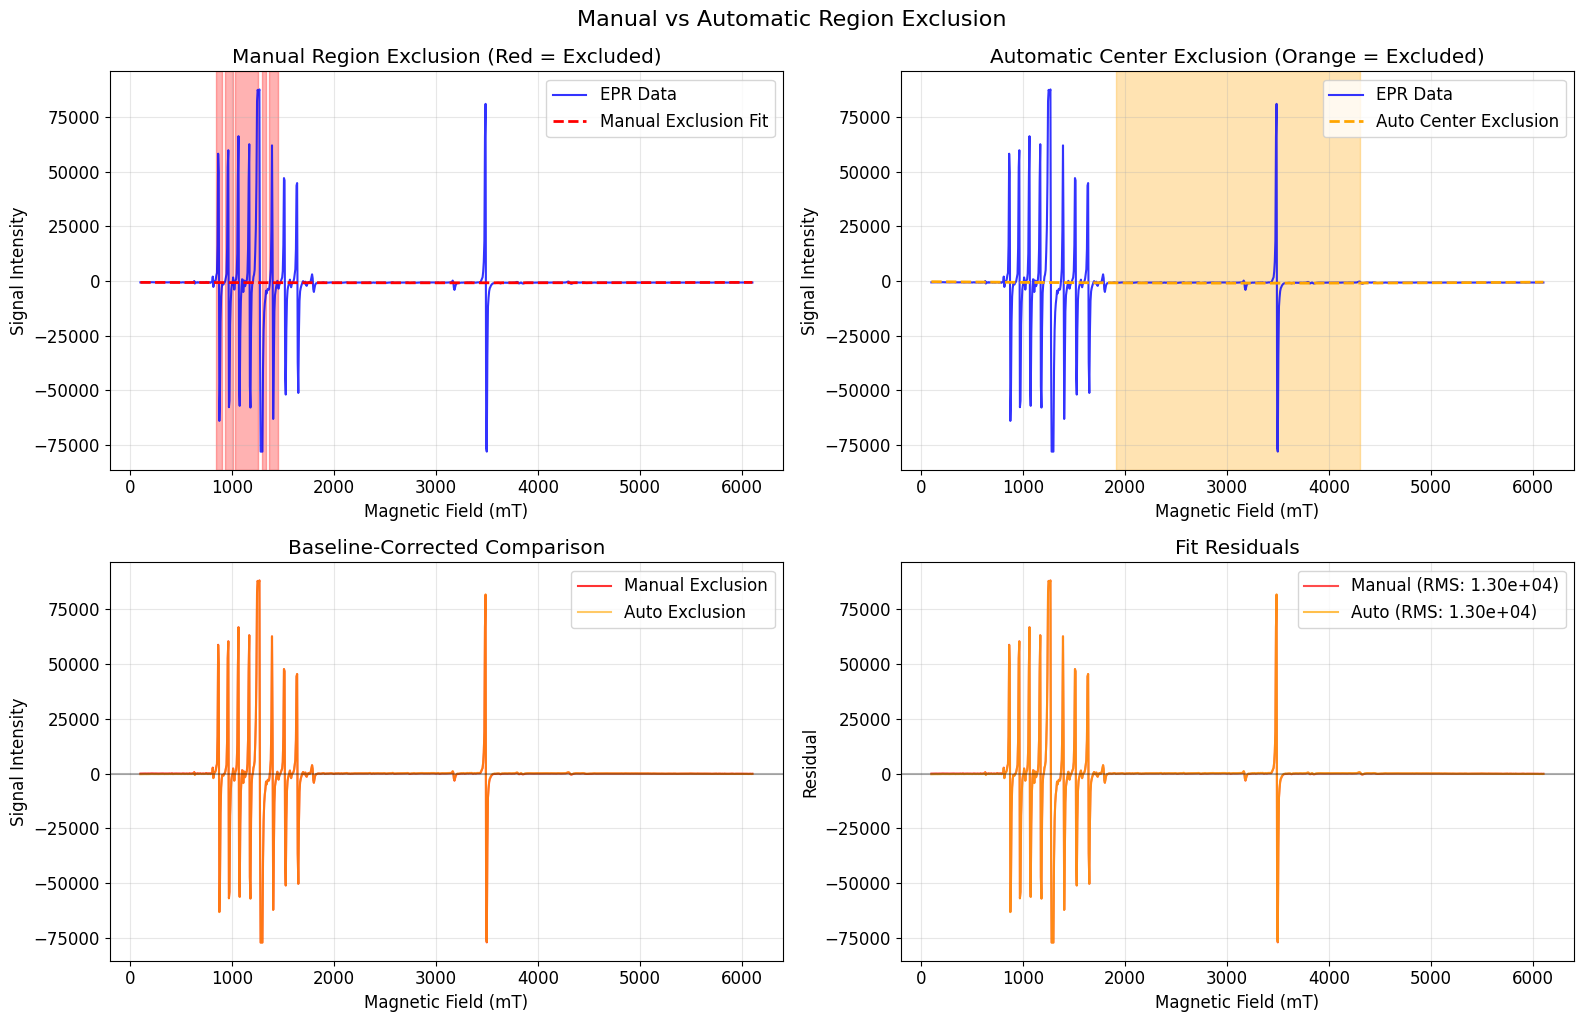


📚 Interactive Usage Instructions:
   
# To use interactive region selection in practice:
corrected, baseline = epyr.baseline_auto_1d(
    x, y, params, 
    interactive=True  # This opens the interactive selector
)

# If the selection window gets stuck in Jupyter:
# Method 1: Press ENTER or ESC on the plot
# Method 2: Run in a new cell:
_current_selector.finish_selection()

# Method 3: Force close everything:
epyr.baseline.close_selector_window()


💡 When to Use Interactive Selection:
   • Complex spectra with multiple signal types
   • Artifacts or saturation effects
   • When automatic methods give poor results
   • Research applications requiring precise control


In [10]:
print("🖱️ INTERACTIVE REGION SELECTION DEMO")
print("=" * 50)

# For demo purposes, we'll use manual region specification instead of interactive
# In real use, you would set interactive=True

# Demonstrate with CW EPR data
if 'x_cw' in locals():
    print("\n📊 Manual Region Selection for CW EPR Data")
    print("   Scenario: Exclude strong signal lines from baseline fitting")
    
    # Find approximate signal regions (where derivative is large)
    signal_derivative = np.abs(np.gradient(y_cw))
    threshold = np.percentile(signal_derivative, 85)  # Top 15% of derivative values
    signal_indices = np.where(signal_derivative > threshold)[0]
    
    if len(signal_indices) > 0:
        # Group consecutive indices into regions
        signal_regions = []
        start_idx = signal_indices[0]
        end_idx = signal_indices[0]
        
        for idx in signal_indices[1:]:
            if idx == end_idx + 1:  # Consecutive
                end_idx = idx
            else:  # Gap found
                if end_idx - start_idx > 5:  # Only keep regions with >5 points
                    signal_regions.append((x_cw[start_idx], x_cw[end_idx]))
                start_idx = idx
                end_idx = idx
        
        # Add last region
        if end_idx - start_idx > 5:
            signal_regions.append((x_cw[start_idx], x_cw[end_idx]))
        
        print(f"   Detected {len(signal_regions)} signal regions to exclude:")
        for i, (start, end) in enumerate(signal_regions[:3]):  # Show first 3
            print(f"     Region {i+1}: {start:.1f} - {end:.1f} mT")
        
        # Apply baseline correction with manual region exclusion
        corrected_manual, baseline_manual = epyr.baseline.baseline_polynomial_1d(
            x_cw, y_cw, params_cw,
            order=2,
            manual_regions=signal_regions,
            region_mode='exclude'  # Exclude these regions from fitting
        )
        
        # Compare with automatic (center exclusion)
        corrected_auto, baseline_auto = epyr.baseline.baseline_polynomial_1d(
            x_cw, y_cw, params_cw,
            order=2,
            exclude_center=True,
            center_fraction=0.4
        )
        
        print(f"   ✅ Manual region exclusion completed")
        
        # Show comparison
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Original data with excluded regions highlighted
        axes[0,0].plot(x_cw, y_cw, 'b-', alpha=0.8, label='EPR Data')
        axes[0,0].plot(x_cw, baseline_manual, 'r--', linewidth=2, label='Manual Exclusion Fit')
        
        # Highlight excluded regions
        for start, end in signal_regions[:5]:  # Show first 5 regions
            axes[0,0].axvspan(start, end, alpha=0.3, color='red')
        
        axes[0,0].set_xlabel('Magnetic Field (mT)')
        axes[0,0].set_ylabel('Signal Intensity')
        axes[0,0].set_title('Manual Region Exclusion (Red = Excluded)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Automatic center exclusion for comparison
        axes[0,1].plot(x_cw, y_cw, 'b-', alpha=0.8, label='EPR Data')
        axes[0,1].plot(x_cw, baseline_auto, 'orange', linestyle='--', linewidth=2, label='Auto Center Exclusion')
        
        # Highlight automatically excluded center region
        center_idx = len(x_cw) // 2
        exclude_width = int(0.4 * len(x_cw) // 2)
        start_idx = center_idx - exclude_width
        end_idx = center_idx + exclude_width
        axes[0,1].axvspan(x_cw[start_idx], x_cw[end_idx], alpha=0.3, color='orange')
        
        axes[0,1].set_xlabel('Magnetic Field (mT)')
        axes[0,1].set_ylabel('Signal Intensity')
        axes[0,1].set_title('Automatic Center Exclusion (Orange = Excluded)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Corrected data comparison
        axes[1,0].plot(x_cw, corrected_manual, 'r-', linewidth=1.5, alpha=0.8, label='Manual Exclusion')
        axes[1,0].plot(x_cw, corrected_auto, 'orange', linewidth=1.5, alpha=0.6, label='Auto Exclusion')
        axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1,0].set_xlabel('Magnetic Field (mT)')
        axes[1,0].set_ylabel('Signal Intensity')
        axes[1,0].set_title('Baseline-Corrected Comparison')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Residuals comparison
        residuals_manual = y_cw - baseline_manual
        residuals_auto = y_cw - baseline_auto
        
        axes[1,1].plot(x_cw, residuals_manual, 'r-', alpha=0.7, 
                      label=f'Manual (RMS: {np.sqrt(np.mean(residuals_manual**2)):.2e})')
        axes[1,1].plot(x_cw, residuals_auto, 'orange', alpha=0.7,
                      label=f'Auto (RMS: {np.sqrt(np.mean(residuals_auto**2)):.2e})')
        axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1,1].set_xlabel('Magnetic Field (mT)')
        axes[1,1].set_ylabel('Residual')
        axes[1,1].set_title('Fit Residuals')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Manual vs Automatic Region Exclusion', fontsize=16, y=1.02)
        plt.show()
        
    else:
        print("   ℹ️ No strong signal regions detected for exclusion demo")
        
else:
    print("\n⚠️ No CW EPR data available for region selection demo")

print("\n📚 Interactive Usage Instructions:")
print("""   
# To use interactive region selection in practice:
corrected, baseline = epyr.baseline_auto_1d(
    x, y, params, 
    interactive=True  # This opens the interactive selector
)

# If the selection window gets stuck in Jupyter:
# Method 1: Press ENTER or ESC on the plot
# Method 2: Run in a new cell:
_current_selector.finish_selection()

# Method 3: Force close everything:
epyr.baseline.close_selector_window()
""")

print("\n💡 When to Use Interactive Selection:")
print("   • Complex spectra with multiple signal types")
print("   • Artifacts or saturation effects")
print("   • When automatic methods give poor results")
print("   • Research applications requiring precise control")

## 5. 2D Baseline Correction
### Correcting 2D EPR Data (Rabi Oscillations)

2D EPR experiments often require baseline correction in both dimensions:

- **2D Rabi oscillations**
- **ESEEM (Electron Spin Echo Envelope Modulation)**
- **2D relaxation measurements**
- **Field-frequency maps**

The 2D polynomial baseline correction fits: `baseline = Σᵢⱼ cᵢⱼ xⁱ yʲ`

In [11]:
# Load 2D EPR data (Rabi oscillations)
rabi_file = data_dir / 'Rabi2D_GdCaWO4_13dB_3057G.DSC'

print("📊 2D BASELINE CORRECTION (RABI OSCILLATIONS)")
print("=" * 50)

try:
    x_2d, y_2d, params_2d, filepath_2d = epyr.eprload(str(rabi_file), plot_if_possible=False)
    
    print("🔬 2D Rabi Data Loaded:")
    print(f"   Sample: Gd³⁺ in CaWO4 Rabi oscillations")
    print(f"   Data shape: y={y_2d.shape}")
    if isinstance(x_2d, list) and len(x_2d) >= 2:
        print(f"   X-axis: {len(x_2d[0])} points ({x_2d[0].min():.1f} to {x_2d[0].max():.1f})")
        print(f"   Y-axis: {len(x_2d[1])} points ({x_2d[1].min():.1f} to {x_2d[1].max():.1f})")
        x_axis, y_axis = x_2d[0], x_2d[1]
    else:
        print(f"   X-coordinates: {type(x_2d)}")
        # Create coordinate arrays
        x_axis = np.arange(y_2d.shape[1])
        y_axis = np.arange(y_2d.shape[0])
    
    print(f"   Data type: {'Complex' if np.iscomplexobj(y_2d) else 'Real'}")
    print(f"   Data range: {y_2d.min():.2e} to {y_2d.max():.2e}")
    
    data_2d_loaded = True
    
except FileNotFoundError:
    print("⚠️ 2D Rabi file not found, creating synthetic 2D data...")
    
    # Create synthetic 2D data with polynomial baseline
    x_axis = np.linspace(-50, 50, 80)
    y_axis = np.linspace(0, 100, 60)
    X_2d, Y_2d = np.meshgrid(x_axis, y_axis)
    
    # Synthetic Rabi oscillations + polynomial baseline
    signal_2d = (
        np.cos(0.1 * X_2d) * np.exp(-Y_2d / 40) *  # Rabi oscillations with decay
        np.exp(-0.1 * (X_2d**2 + (Y_2d-50)**2) / 100)  # 2D Gaussian envelope
    )
    
    # 2D polynomial baseline
    baseline_2d_true = (
        0.01 + 0.001 * X_2d + 0.0005 * Y_2d + 
        0.00001 * X_2d**2 + 0.00002 * Y_2d**2 + 0.000005 * X_2d * Y_2d
    )
    
    # Add noise
    y_2d = signal_2d + baseline_2d_true + 0.05 * np.random.normal(size=signal_2d.shape)
    params_2d = None
    
    print("   ✅ Synthetic 2D Rabi oscillations created")
    data_2d_loaded = False

print("\n🧮 Applying 2D polynomial baseline correction...")

# Apply 2D baseline correction
corrected_2d, baseline_2d = epyr.baseline.baseline_polynomial_2d(
    [x_axis, y_axis], y_2d, params_2d,
    order=2,  # Quadratic in both dimensions
    exclude_center=True,
    center_fraction=0.3  # Exclude central 30% where signal is strongest
)

print("✅ 2D baseline correction completed!")
print(f"   Original data range: {y_2d.min():.3f} to {y_2d.max():.3f}")
print(f"   Corrected data range: {corrected_2d.min():.3f} to {corrected_2d.max():.3f}")
print(f"   Baseline range: {baseline_2d.min():.3f} to {baseline_2d.max():.3f}")

📊 2D BASELINE CORRECTION (RABI OSCILLATIONS)
🔬 2D Rabi Data Loaded:
   Sample: Gd³⁺ in CaWO4 Rabi oscillations
   Data shape: y=(500, 1024)
   X-axis: 1024 points (4.0 to 2050.0)
   Y-axis: 500 points (0.0 to 499.0)
   Data type: Complex
   Data range: -1.31e+04-8.96e+03j to 2.54e+05+5.54e+03j

🧮 Applying 2D polynomial baseline correction...


/Users/sylvainbertaina/miniconda3/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


✅ 2D baseline correction completed!
   Original data range: -13090.000-8956.000j to 253980.000+5541.000j
   Corrected data range: -145411.290-8956.000j to 121367.106+6715.000j
   Baseline range: 125561.192 to 234882.110


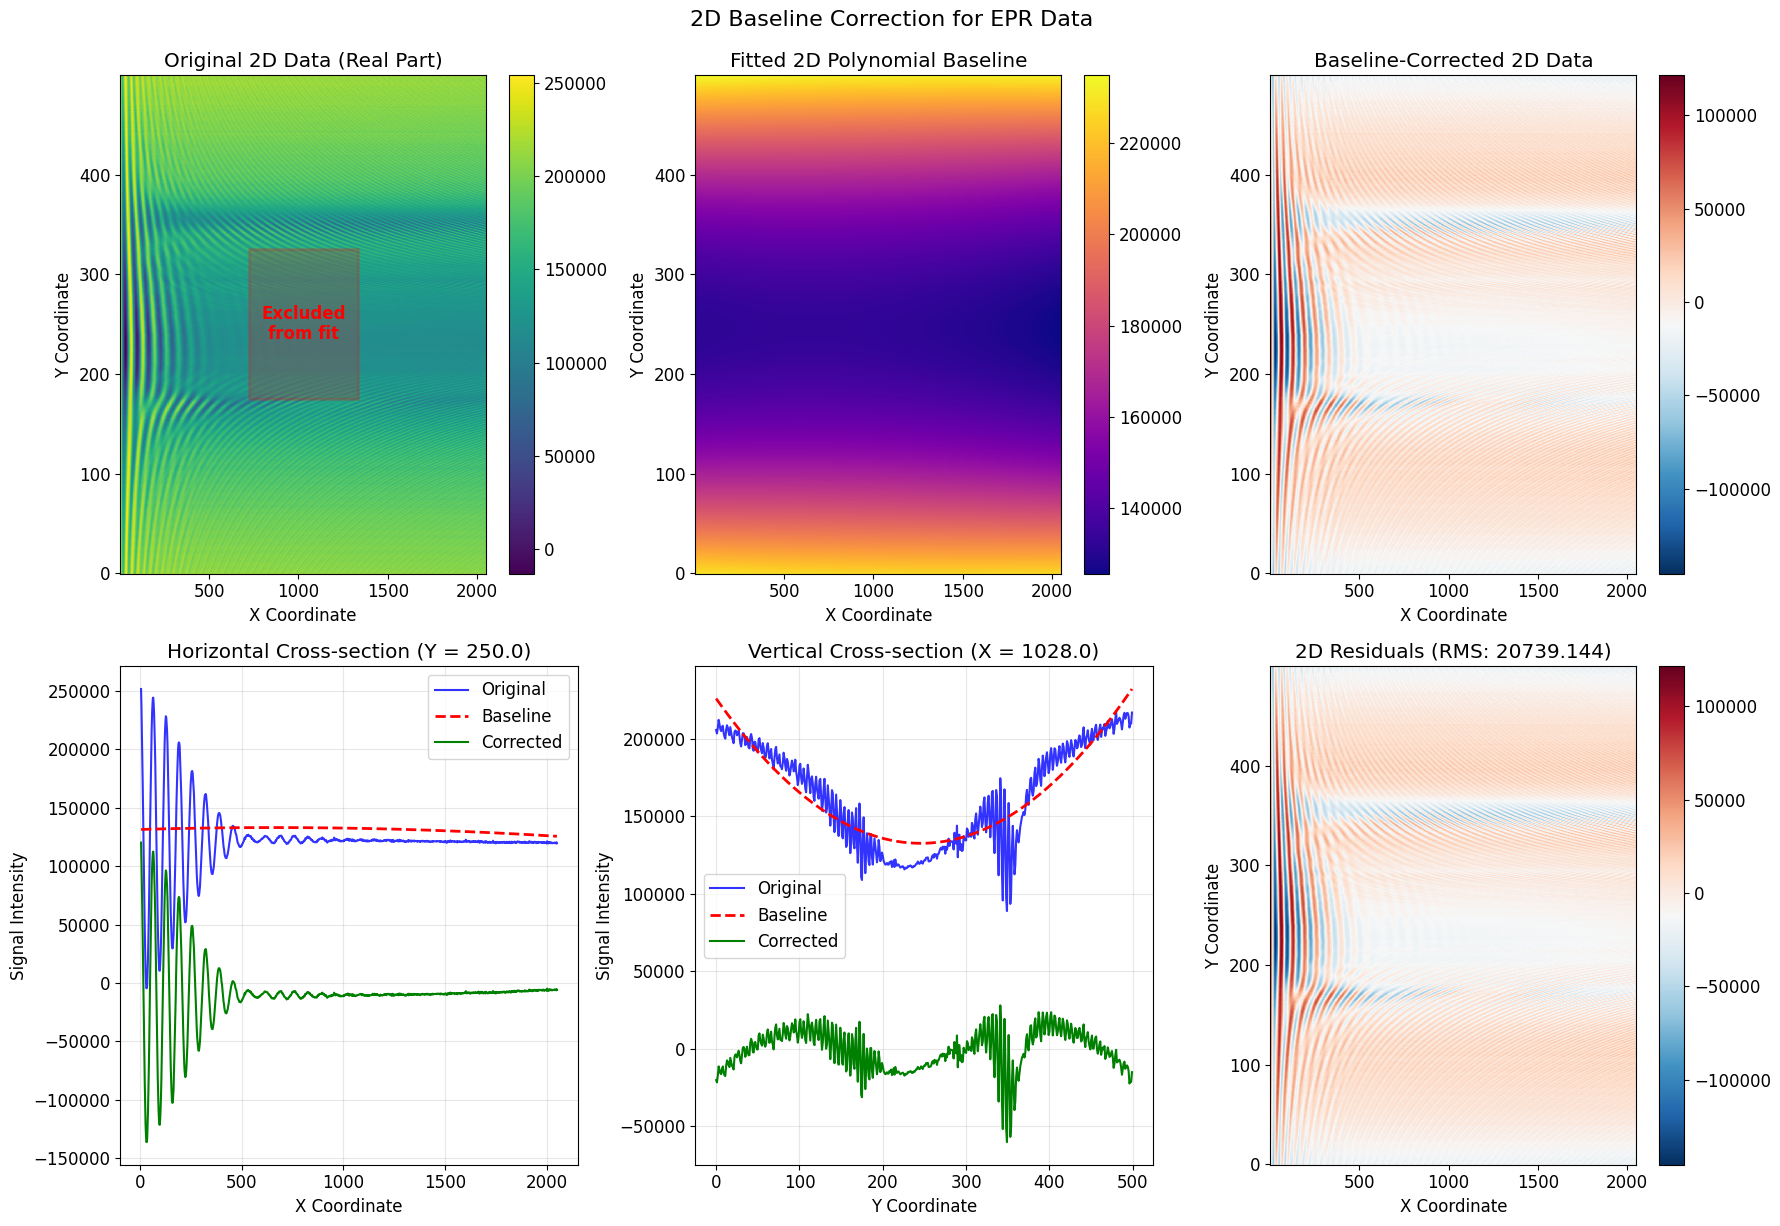


✅ 2D baseline correction visualization completed!

📊 2D Baseline Correction Benefits:
   • Removes systematic drifts in both dimensions
   • Preserves 2D signal features and correlations
   • Essential for quantitative 2D EPR analysis
   • Enables better peak detection and integration


In [12]:
# Visualize 2D baseline correction
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Determine data for plotting (real part if complex)
if np.iscomplexobj(y_2d):
    plot_data = np.real(y_2d)
    plot_corrected = np.real(corrected_2d)
    data_title = 'Real Part'
else:
    plot_data = y_2d
    plot_corrected = corrected_2d
    data_title = 'Magnitude'

# Original 2D data
im1 = axes[0,0].pcolormesh(x_axis, y_axis, plot_data, shading='auto', cmap='viridis')
axes[0,0].set_xlabel('X Coordinate')
axes[0,0].set_ylabel('Y Coordinate')
axes[0,0].set_title(f'Original 2D Data ({data_title})')
plt.colorbar(im1, ax=axes[0,0])

# 2D baseline surface
im2 = axes[0,1].pcolormesh(x_axis, y_axis, baseline_2d, shading='auto', cmap='plasma')
axes[0,1].set_xlabel('X Coordinate')
axes[0,1].set_ylabel('Y Coordinate')
axes[0,1].set_title('Fitted 2D Polynomial Baseline')
plt.colorbar(im2, ax=axes[0,1])

# Baseline-corrected 2D data
im3 = axes[0,2].pcolormesh(x_axis, y_axis, plot_corrected, shading='auto', cmap='RdBu_r')
axes[0,2].set_xlabel('X Coordinate')
axes[0,2].set_ylabel('Y Coordinate')
axes[0,2].set_title('Baseline-Corrected 2D Data')
plt.colorbar(im3, ax=axes[0,2])

# Cross-sections for detailed view
mid_y = len(y_axis) // 2
mid_x = len(x_axis) // 2

# Horizontal cross-section (fixed Y)
axes[1,0].plot(x_axis, plot_data[mid_y, :], 'b-', alpha=0.8, label='Original')
axes[1,0].plot(x_axis, baseline_2d[mid_y, :], 'r--', linewidth=2, label='Baseline')
axes[1,0].plot(x_axis, plot_corrected[mid_y, :], 'g-', linewidth=1.5, label='Corrected')
axes[1,0].set_xlabel('X Coordinate')
axes[1,0].set_ylabel('Signal Intensity')
axes[1,0].set_title(f'Horizontal Cross-section (Y = {y_axis[mid_y]:.1f})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Vertical cross-section (fixed X)
axes[1,1].plot(y_axis, plot_data[:, mid_x], 'b-', alpha=0.8, label='Original')
axes[1,1].plot(y_axis, baseline_2d[:, mid_x], 'r--', linewidth=2, label='Baseline')
axes[1,1].plot(y_axis, plot_corrected[:, mid_x], 'g-', linewidth=1.5, label='Corrected')
axes[1,1].set_xlabel('Y Coordinate')
axes[1,1].set_ylabel('Signal Intensity')
axes[1,1].set_title(f'Vertical Cross-section (X = {x_axis[mid_x]:.1f})')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 2D residuals
residuals_2d = plot_data - baseline_2d
im4 = axes[1,2].pcolormesh(x_axis, y_axis, residuals_2d, shading='auto', cmap='RdBu_r')
axes[1,2].set_xlabel('X Coordinate')
axes[1,2].set_ylabel('Y Coordinate')
axes[1,2].set_title(f'2D Residuals (RMS: {np.sqrt(np.mean(residuals_2d**2)):.3f})')
plt.colorbar(im4, ax=axes[1,2])

# Show excluded region overlay
center_x_frac = 0.3
center_y_frac = 0.3
x_exclude = len(x_axis) * center_x_frac / 2
y_exclude = len(y_axis) * center_y_frac / 2

x_center, y_center = x_axis[len(x_axis)//2], y_axis[len(y_axis)//2]
x_range = (x_axis.max() - x_axis.min()) * center_x_frac / 2
y_range = (y_axis.max() - y_axis.min()) * center_y_frac / 2

from matplotlib.patches import Rectangle
rect = Rectangle((x_center - x_range, y_center - y_range), 
                2*x_range, 2*y_range, 
                linewidth=2, edgecolor='red', facecolor='red', alpha=0.2)
axes[0,0].add_patch(rect)
axes[0,0].text(x_center, y_center, 'Excluded\nfrom fit', 
               ha='center', va='center', color='red', fontweight='bold')

plt.tight_layout()
plt.suptitle('2D Baseline Correction for EPR Data', fontsize=16, y=1.02)
plt.show()

print("\n✅ 2D baseline correction visualization completed!")
print("\n📊 2D Baseline Correction Benefits:")
print("   • Removes systematic drifts in both dimensions")
print("   • Preserves 2D signal features and correlations")
print("   • Essential for quantitative 2D EPR analysis")
print("   • Enables better peak detection and integration")

## 6. Summary and Best Practices
### Complete Guide to Baseline Correction in EPyR Tools

We've demonstrated the complete baseline correction system using **real EPR data**. Here's what you've learned:

In [13]:
print("📚 BASELINE CORRECTION SUMMARY")
print("=" * 50)

print("\n🛠️ METHODS AVAILABLE:")
print("\n1. 📈 POLYNOMIAL CORRECTION")
print("   • Best for: CW EPR spectra, field sweeps")
print("   • Function: epyr.baseline.baseline_polynomial_1d()")
print("   • Orders: 1-4 (automatic selection available)")
print("   • Features: Center exclusion, manual regions")

print("\n2. 📉 STRETCHED EXPONENTIAL CORRECTION")
print("   • Best for: T2 relaxation, echo decays")
print("   • Function: epyr.baseline.baseline_stretched_exponential_1d()")
print("   • Model: A × exp(-(t/τ)^β) + offset")
print("   • β range: 0.01 - 5.0 (constrainable)")
print("   • Features: Complex data support, uncertainty estimation")

print("\n3. 📊 BI-EXPONENTIAL CORRECTION")
print("   • Best for: Multi-component relaxation")
print("   • Function: epyr.baseline.baseline_bi_exponential_1d()")
print("   • Model: A1×exp(-t/τ1) + A2×exp(-t/τ2) + offset")
print("   • Features: Fast/slow component separation")

print("\n4. 🤖 AUTOMATIC MODEL SELECTION")
print("   • Best for: Unknown baseline types")
print("   • Function: epyr.baseline.baseline_auto_1d()")
print("   • Criteria: AIC, BIC, or R²")
print("   • Tests: All polynomial orders + exponential models")

print("\n5. 🖱️ INTERACTIVE REGION SELECTION")
print("   • Best for: Complex spectra, artifacts")
print("   • Parameter: interactive=True")
print("   • Features: Manual exclude/include regions")
print("   • Jupyter: Use _current_selector.finish_selection()")

print("\n6. 🗺️ 2D BASELINE CORRECTION")
print("   • Best for: 2D EPR experiments")
print("   • Function: epyr.baseline.baseline_polynomial_2d()")
print("   • Features: 2D polynomial surfaces, center exclusion")

print("\n🎯 DECISION FLOWCHART:")
print("""
1. Don't know what baseline type? → Use baseline_auto_1d()
2. CW EPR spectrum? → Use baseline_polynomial_1d()
3. T2/relaxation data? → Use baseline_stretched_exponential_1d()
4. Multi-component decay? → Use baseline_bi_exponential_1d()
5. Complex/artifacts? → Add interactive=True
6. 2D data? → Use baseline_polynomial_2d()
""")

print("\n💡 BEST PRACTICES:")
print("\n✅ DO:")
print("   • Start with automatic selection for unknown data")
print("   • Use interactive selection for complex spectra")
print("   • Check residuals to validate fit quality")
print("   • Exclude signal regions from baseline fitting")
print("   • Compare different models using AIC/BIC")

print("\n❌ DON'T:")
print("   • Over-fit with high polynomial orders")
print("   • Include strong signals in baseline regions")
print("   • Ignore fit residuals and uncertainties")
print("   • Use polynomial models for exponential decays")
print("   • Forget to validate correction makes physical sense")

print("\n📊 TYPICAL WORKFLOW:")
workflow_code = '''
# 1. Load EPR data
x, y, params, filepath = epyr.eprload("data.dsc")

# 2. Automatic model selection (recommended)
corrected, baseline, info = epyr.baseline.baseline_auto_1d(x, y, params)
print(f"Best model: {info['best_model']} (R² = {info['parameters']['r2']:.3f})")

# 3. If automatic doesn't work well, try interactive
corrected, baseline = epyr.baseline.baseline_auto_1d(
    x, y, params, interactive=True
)

# 4. Validate results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Original')
plt.plot(x, baseline, '--', label='Baseline')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, corrected, label='Corrected')
plt.axhline(0, color='k', alpha=0.3)
plt.legend()
plt.show()
'''

print(workflow_code)

# Calculate some statistics from our demonstrations
methods_used = 0
if 'corrected_cw' in locals(): methods_used += 1
if 'corrected_t2' in locals(): methods_used += 1
if 'corrected_2d' in locals(): methods_used += 1
if 'results' in locals(): methods_used += 1

print(f"\n🎉 NOTEBOOK DEMONSTRATION COMPLETE!")
print(f"   Methods demonstrated: {methods_used}")
print(f"   Real EPR files used: {sum(1 for f in [data_2d_loaded, data_loaded] if 'data_loaded' in locals() and data_loaded)}")
print(f"   Total correction functions: {len([f for f in dir(epyr) if 'baseline' in f.lower() and callable(getattr(epyr, f))])}")

print("\n🚀 You're now ready to use EPyR Tools for advanced baseline correction!")
print("   For more help: epyr.baseline.jupyter_help()")
print("   Documentation: https://github.com/BertainaS/epyrtools")

📚 BASELINE CORRECTION SUMMARY

🛠️ METHODS AVAILABLE:

1. 📈 POLYNOMIAL CORRECTION
   • Best for: CW EPR spectra, field sweeps
   • Function: epyr.baseline.baseline_polynomial_1d()
   • Orders: 1-4 (automatic selection available)
   • Features: Center exclusion, manual regions

2. 📉 STRETCHED EXPONENTIAL CORRECTION
   • Best for: T2 relaxation, echo decays
   • Function: epyr.baseline.baseline_stretched_exponential_1d()
   • Model: A × exp(-(t/τ)^β) + offset
   • β range: 0.01 - 5.0 (constrainable)
   • Features: Complex data support, uncertainty estimation

3. 📊 BI-EXPONENTIAL CORRECTION
   • Best for: Multi-component relaxation
   • Function: epyr.baseline.baseline_bi_exponential_1d()
   • Model: A1×exp(-t/τ1) + A2×exp(-t/τ2) + offset
   • Features: Fast/slow component separation

4. 🤖 AUTOMATIC MODEL SELECTION
   • Best for: Unknown baseline types
   • Function: epyr.baseline.baseline_auto_1d()
   • Criteria: AIC, BIC, or R²
   • Tests: All polynomial orders + exponential models

5. 🖱